Challenges:
* Sentinel Data when cloud or snow filtering limits data for winter 
* Overlap data is included a lot more than non-overlap reigions
* Window size of rollilng mean can affect estimates significantly

**Michigan Winter Wheat Stages (For Reference)**

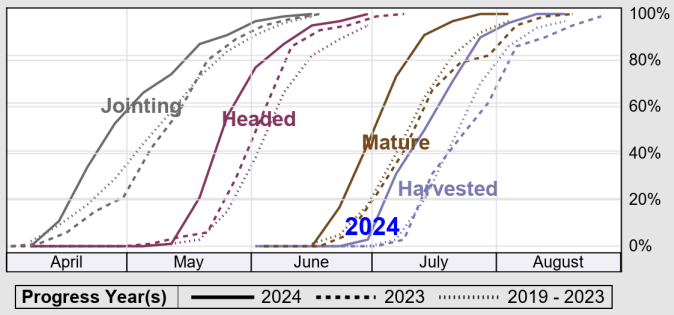

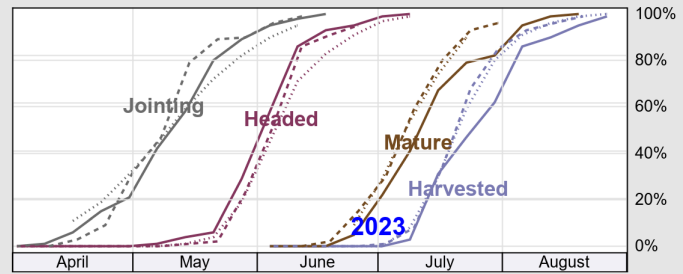

### Import

In [18]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import stackstac
import xarray as xr

## 2024

### Load Sentinel2 Data 2024

In [ ]:
import json
from shapely.geometry import shape
from pystac_client import Client

# Step 1: Load the GeoJSON file
with open("huron_county.geojson") as f:
    geojson = json.load(f)

# Step 2: Extract the geometry (assumes single feature)
geometry = shape(geojson["features"][0]["geometry"])

# Step 3: Use as `intersects` in your STAC search
catalog = Client.open("https://earth-search.aws.element84.com/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geometry,
    datetime="2024-01-01/2024-05-14",
    query={"eo:cloud_cover": {"lt": 40}},
    max_items=5000,
    
    #limit=5
)


In [228]:
# # Step 4: Collect and inspect results
items = list(search.items())
print(f"Found {len(items)} Sentinel-2 scenes for Huron County in June 2024")


print("Available bands in first scene:")
for asset_key in items[0].assets.keys():
    print(" -", asset_key)

Found 24 Sentinel-2 scenes for Huron County in June 2024
Available bands in first scene:
 - aot
 - blue
 - coastal
 - granule_metadata
 - green
 - nir
 - nir08
 - nir09
 - red
 - rededge1
 - rededge2
 - rededge3
 - scl
 - swir16
 - swir22
 - thumbnail
 - tileinfo_metadata
 - visual
 - wvp
 - aot-jp2
 - blue-jp2
 - coastal-jp2
 - green-jp2
 - nir-jp2
 - nir08-jp2
 - nir09-jp2
 - red-jp2
 - rededge1-jp2
 - rededge2-jp2
 - rededge3-jp2
 - scl-jp2
 - swir16-jp2
 - swir22-jp2
 - visual-jp2
 - wvp-jp2


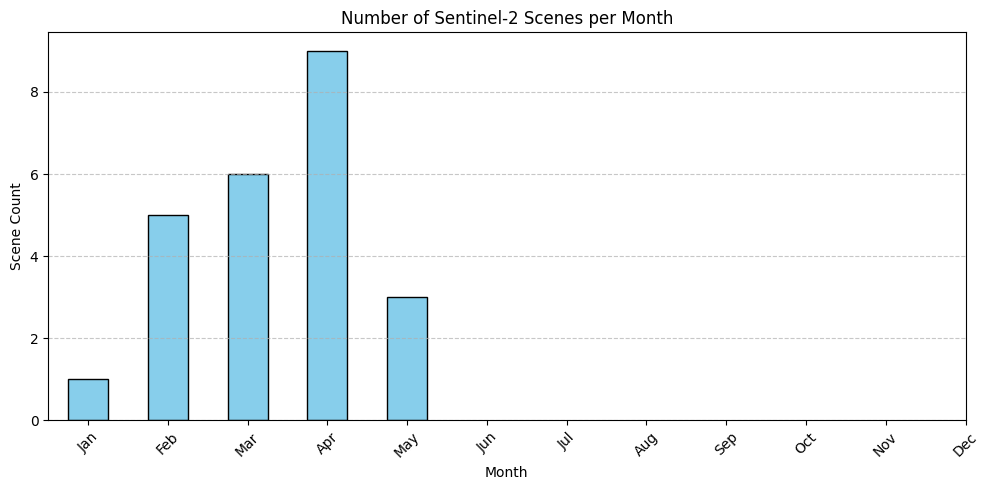

In [229]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract dates from STAC items
dates = [item.datetime.date() for item in items]
df = pd.DataFrame(dates, columns=["date"])

# Extract month and year
df["month"] = df["date"].apply(lambda d: d.month)
df["year"] = df["date"].apply(lambda d: d.year)

# Group by month and count scenes
monthly_counts = df.groupby("month").size()

# Plot
plt.figure(figsize=(10, 5))
monthly_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Sentinel-2 Scenes per Month")
plt.xlabel("Month")
plt.ylabel("Scene Count")
plt.xticks(ticks=range(0, 12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [230]:
tile_ids = set(item.id.split("_")[1] for item in items)
print("Tiles found in search:", tile_ids)


Tiles found in search: {'17TLJ', '16TGP'}


In [231]:
from pyproj import Transformer
from shapely.ops import transform

project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds


Ok, so we are going to get the 2024 wheat and then get break dormancy date from it. Then we will compare it to using the whole county and see if there is a difference.

In [232]:
import stackstac
# Stack with blue added
stack = stackstac.stack(
    items,
    assets=["blue", "red", "nir", "scl"],
    resolution=10,
    epsg=32617,
    dtype="float64",
    bounds=(minx, miny, maxx, maxy),
)


# Select bands
blue = stack.sel(band="blue")
red = stack.sel(band="red")
nir = stack.sel(band="nir")
scl = stack.sel(band="scl")

# # Cloud mask: 1 - saturated/defective, 3 - shadows, 8–10 - clouds, 11 - snow/ice
# cloud_mask = ~scl.isin([1, 3, 8, 9, 10, 11])

# # Sentinel-2 SCL land classes to keep (typically: 4 = vegetation, 5 = bare, etc.)
# # Exclude 6 (water), 0 (no data), and other unwanted classes if desired
# land_mask = scl.isin([4, 5])

# valid_mask = land_mask & cloud_mask


# Mask out water, cloud, shadows, snow, and no data
bad_scl = [0, 1, 3, 6, 7, 8, 9, 10, 11]  # adds: 0 = no data, 6 = water, 7 = unclassified
valid_mask = ~scl.isin(bad_scl)

# bad_scl = [0, 1, 3, 6, 9, 10, 11]  # Keep SCL=7 (unclassified) and 8 (medium clouds)
# valid_mask = ~scl.isin(bad_scl)



# Apply mask to bands
blue_masked = blue.where(valid_mask)
red_masked = red.where(valid_mask)
nir_masked = nir.where(valid_mask)

# EVI calculation
evi = 2.5 * (nir_masked - red_masked) / (
    nir_masked + 6 * red_masked - 7.5 * blue_masked + 1
)

# Add time dimension
evi = evi.assign_coords(time=stack.time)

# Optional: Clip to valid EVI range
evi = evi.clip(min=-1.0, max=1.0)


In [233]:
import geopandas as gpd
import rioxarray

# Load wheat field boundaries for 2024
wheat_gdf = gpd.read_file("huron_winter_wheat_2024.geojson").to_crs("EPSG:32617")

# Attach CRS to EVI if not already present
evi.rio.write_crs("EPSG:32617", inplace=True)

# Clip EVI stack to just 2024 wheat field polygons
evi_clipped = evi.rio.clip(wheat_gdf.geometry.values, wheat_gdf.crs, drop=True)

In [234]:
evi_clipped

<xarray.DataArray 'stackstac-6ae90558086f7358a5a1079729d0a17a' (time: 24,
                                                                y: 4228, x: 6894)> Size: 6GB
dask.array<getitem, shape=(24, 4228, 6894), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
    id                                       (time) <U24 2kB 'S2B_17TLJ_20240...
  * x                                        (x) float64 55kB 3.014e+05 ... 3...
  * y                                        (y) float64 34kB 4.88e+06 ... 4....
    s2:granule_id                            (time) <U62 6kB 'S2B_OPER_MSI_L2...
    s2:high_proba_clouds_percentage          (time) float64 192B 1.703 ... 7.053
    s2:medium_proba_clouds_percentage        (time) float64 192B 4.404 ... 7.744
    ...                                       ...
    earthsearch:payload_id                   (time) <U74 7kB 'roda-sentinel2/...
    s2:degraded_msi_data_percentage          (time) object 192B 0.0304 ... 0....
    s2:not_vegetated_percentage              (time) float64 192B 3.233 ... 21.76
    epsg                                     int64 8B 32617
  * time                                     (time) datetime64[ns] 192B 2024-...
    spatial_ref                              int64 8B 0

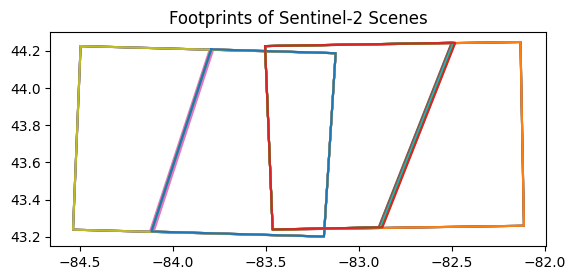

In [235]:
import matplotlib.pyplot as plt
from shapely.geometry import shape

geoms = [shape(item.geometry) for item in items]
for g in geoms:
    xs, ys = g.exterior.xy
    plt.plot(xs, ys)
plt.title("Footprints of Sentinel-2 Scenes")
plt.gca().set_aspect("equal")


### Predicting Green-up (per-pixel) [NOT ENOUGH RAM]

We will use the inflection point method which gets the first derivative of the EVI time-series by pixel and then finds the max which will be the green up date (should be)

In [31]:
import numpy as np
import xarray as xr

# How many time steps?
n_time = evi.sizes["time"]

# Get time values (for metadata later)
time_values = evi.time.values

# Create list to store each time slice
evi_list = []

# Loop through each time index
for t in range(n_time):
    print(f"Extracting time index {t+1}/{n_time}...")
    band = evi.isel(time=t)
    arr = band.values  # this safely avoids Dask compute
    evi_list.append(arr)

# Stack into final 3D NumPy array (time, y, x)
evi_stack = np.stack(evi_list, axis=0)
print("✅ EVI stack shape:", evi_stack.shape)


Extracting time index 1/20...
Extracting time index 2/20...
Extracting time index 3/20...
Extracting time index 4/20...
Extracting time index 5/20...
Extracting time index 6/20...
Extracting time index 7/20...
Extracting time index 8/20...
Extracting time index 9/20...
Extracting time index 10/20...
Extracting time index 11/20...
Extracting time index 12/20...
Extracting time index 13/20...
Extracting time index 14/20...
Extracting time index 15/20...
Extracting time index 16/20...
Extracting time index 17/20...
Extracting time index 18/20...
Extracting time index 19/20...
Extracting time index 20/20...
✅ EVI stack shape: (20, 4358, 6943)


In [32]:
np.save('evi2024.npy', evi_stack)

Load in the stack

In [9]:
evi_stack=np.load('evi2024.npy')

In [10]:
# Get y and x coordinates
y_coords = evi.y.values
x_coords = evi.x.values
time_values = evi.time.values

# # Rebuild clean xarray object
# evi_clean_pixel = xr.DataArray(
#     data=evi_stack,
#     dims=["time", "y", "x"],
#     coords={"time": time_values, "y": y_coords, "x": x_coords},
#     name="evi"
# )


In [11]:
import dask.array as da

evi_clean_pixel = xr.DataArray(
    da.from_array(evi_stack, chunks=("auto", 256, 256)),  # or manual chunk sizes
    dims=["time", "y", "x"],
    coords={"time": time_values, "y": y_coords, "x": x_coords},
    name="evi"
)


In [12]:
import numpy as np
import xarray as xr
from scipy.signal import savgol_filter

def smooth_and_greenup_numpy(pixel_ts, time_days, window=9, poly=2):
    if np.isnan(pixel_ts).all():
        return np.nan
    try:
        ts_smooth = savgol_filter(pixel_ts, window_length=window, polyorder=poly)
        deriv = np.gradient(ts_smooth, time_days)
        return time_days[np.argmax(deriv)]
    except:
        return np.nan

def compute_greenup_doy_dask(evi: xr.DataArray, window=9, poly=2) -> xr.DataArray:
    """
    Parallel Dask version: computes green-up DOY from EVI using max first derivative.
    """
    # Rechunk time to a single chunk (needed for apply_ufunc with core_dims=['time'])
    evi = evi.chunk({'time': -1})

    # Create time_days (in days since first day)
    first_day = np.datetime64(evi.time.values[0], 'D')
    time_days = (evi.time.values - first_day).astype('timedelta64[D]').astype(int)

    # Broadcast time_days so it's available to all blocks
    time_days_da = xr.DataArray(time_days, dims=["time"])

    # Apply function with parallelization
    greenup_doy = xr.apply_ufunc(
        smooth_and_greenup_numpy,
        evi,
        time_days_da,
        input_core_dims=[["time"], ["time"]],
        output_dtypes=[float],  # allow NaNs to be represented
        dask="parallelized",
        vectorize=True,
        kwargs={'window': window, 'poly': poly},
    )

    greenup_doy.name = "greenup_doy"
    greenup_doy.attrs['description'] = "Day of year of max smoothed EVI slope"
    return greenup_doy


In [13]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar

# Step 1: Start Dask Client for parallel execution and dashboard
client = Client(n_workers=4, threads_per_worker=2)  # Adjust based on your CPU

# (Optional) Show link to dashboard
print("Dask dashboard running at:", client.dashboard_link)

# Step 2: Build lazy computation graph
greenup_doy = compute_greenup_doy_dask(evi_clean_pixel)

# Step 3: Trigger computation with progress bar
with ProgressBar():
    greenup_doy = greenup_doy.compute()

# Step 4: Save result
greenup_doy.rio.write_crs("EPSG:32617", inplace=True)
greenup_doy.rio.to_raster("greenup_doy_dask.tif")


Dask dashboard running at: http://127.0.0.1:8787/status


2025-05-27 18:19:00,634 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\tornado\websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\tornado\web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\bokeh\server\views\ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration if necessary")
bokeh.protocol.exceptions.P

KeyboardInterrupt: 

### Downsampled

In [236]:
evi_downsampled = evi.coarsen(x=50, y=50, boundary="trim").mean()

In [237]:
evi_downsampled

<xarray.DataArray 'stackstac-6ae90558086f7358a5a1079729d0a17a' (time: 24,
                                                                y: 87, x: 138)> Size: 2MB
dask.array<mean_agg-aggregate, shape=(24, 87, 138), dtype=float64, chunksize=(1, 20, 20), chunktype=numpy.ndarray>
Coordinates: (12/46)
    id                                       (time) <U24 2kB 'S2B_17TLJ_20240...
  * x                                        (x) float64 1kB 3.014e+05 ... 3....
  * y                                        (y) float64 696B 4.881e+06 ... 4...
    s2:granule_id                            (time) <U62 6kB 'S2B_OPER_MSI_L2...
    s2:high_proba_clouds_percentage          (time) float64 192B 1.703 ... 7.053
    s2:medium_proba_clouds_percentage        (time) float64 192B 4.404 ... 7.744
    ...                                       ...
    earthsearch:payload_id                   (time) <U74 7kB 'roda-sentinel2/...
    s2:degraded_msi_data_percentage          (time) object 192B 0.0304 ... 0....
    s2:not_vegetated_percentage              (time) float64 192B 3.233 ... 21.76
    epsg                                     int64 8B 32617
  * time                                     (time) datetime64[ns] 192B 2024-...
    spatial_ref                              int64 8B 0

In [85]:
import numpy as np
import xarray as xr

# How many time steps?
n_time = evi_downsampled.sizes["time"]

# Get time values (for metadata later)
time_values = evi_downsampled.time.values

# Create list to store each time slice
evi_list = []

# Loop through each time index
for t in range(n_time):
    print(f"Extracting time index {t+1}/{n_time}...")
    band = evi_downsampled.isel(time=t)
    arr = band.values  # this safely avoids Dask compute
    evi_list.append(arr)

# Stack into final 3D NumPy array (time, y, x)
evi_stack = np.stack(evi_list, axis=0)
print("✅ EVI stack shape:", evi_stack.shape)


Extracting time index 1/24...
Extracting time index 2/24...
Extracting time index 3/24...
Extracting time index 4/24...
Extracting time index 5/24...
Extracting time index 6/24...
Extracting time index 7/24...
Extracting time index 8/24...
Extracting time index 9/24...
Extracting time index 10/24...
Extracting time index 11/24...
Extracting time index 12/24...
Extracting time index 13/24...
Extracting time index 14/24...
Extracting time index 15/24...
Extracting time index 16/24...
Extracting time index 17/24...
Extracting time index 18/24...
Extracting time index 19/24...
Extracting time index 20/24...
Extracting time index 21/24...
Extracting time index 22/24...
Extracting time index 23/24...
Extracting time index 24/24...
✅ EVI stack shape: (24, 87, 138)


In [86]:
np.save('downsampled_2024.npy', evi_stack)

In [238]:
evi_stack=np.load('downsampled_2024.npy')
time_values = evi_downsampled.time.values

In [239]:
# Get y and x coordinates
y_coords = evi_downsampled.y.values
x_coords = evi_downsampled.x.values

# Rebuild clean xarray object
evi_clean = xr.DataArray(
    data=evi_stack,
    dims=["time", "y", "x"],
    coords={"time": time_values, "y": y_coords, "x": x_coords},
    name="evi"
)

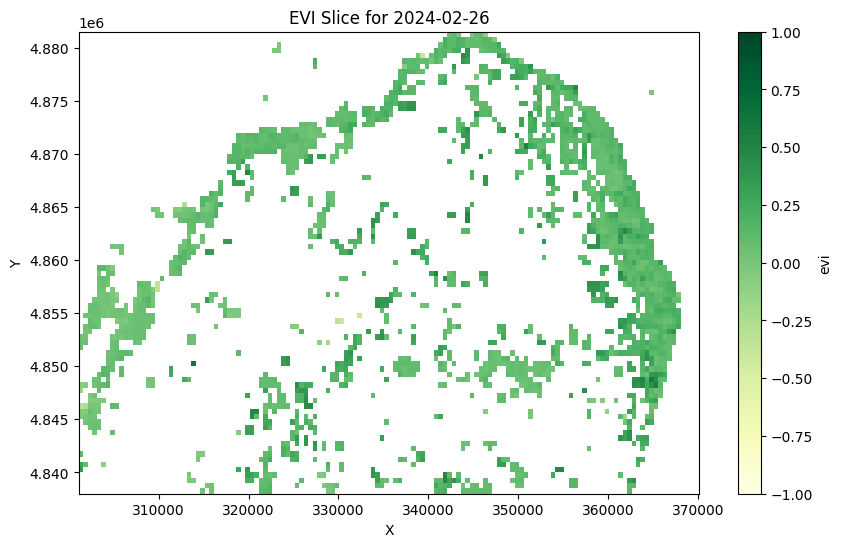

In [240]:
import matplotlib.pyplot as plt

# Choose a time index (e.g. 0 for first date, or 5 for later)
evi_clean.isel(time=0).plot(
    cmap="YlGn",
    vmin=-1, vmax=1,
    figsize=(10, 6)
)
plt.title(f"EVI Slice for {str(evi_clean.time.values[5])[:10]}")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Text(0.5, 1.0, 'Number of Valid EVI Observations')

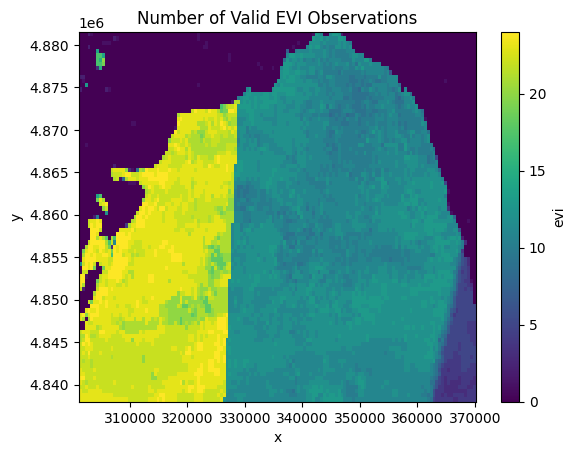

In [157]:
valid_counts = evi_clean.notnull().sum(dim="time")
valid_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Rolling Mean with the whole down-sampled EVI

Processing pixels: 100%|██████████| 12006/12006 [00:01<00:00, 7236.18it/s]


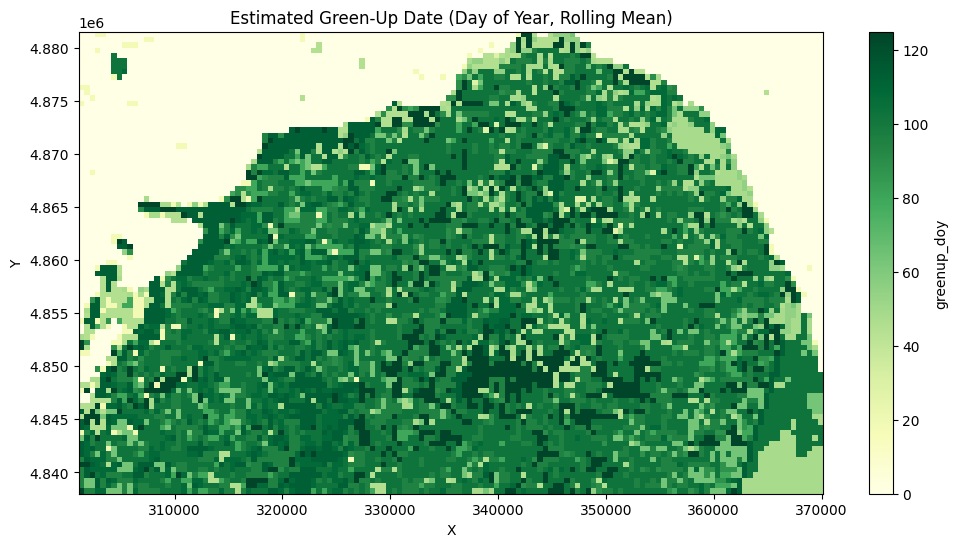

In [158]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = evi_clean.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = evi_clean.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Apply rolling mean smoothing with a window of 5
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=5, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = evi_clean.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year), with optional adjustment
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year
).astype("timedelta64[D]").astype("int16")

# Optional: adjust backward to approximate actual green-up onset
adjust_days = 7
days_since_jan1 = np.clip(days_since_jan1 - adjust_days, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": evi_clean.y, "x": evi_clean.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year, Rolling Mean)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [159]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")


Planting Date Stats (DOY Since Jan 1):
  Mean   : 94.9
  Median : 103.0
  Mode   : 103.0
  StdDev : 23.0
  Min    : 18.0
  Max    : 125.0


### Overlap

7.922823168856888
24
<class 'int'>


Text(0.5, 1.0, 'Number of Valid EVI Observations')

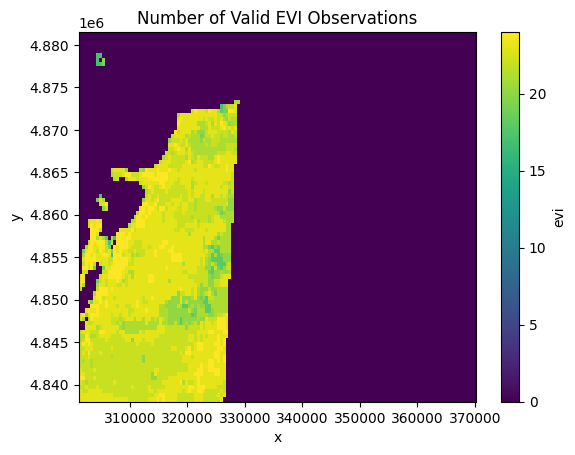

In [160]:
max_val = valid_counts.max().item()
std_dev=valid_counts.std().item()

print(std_dev)
print(max_val)              
print(type(max_val))        

# valid_index=(valid_counts==max_val)
valid_index=(valid_counts>=(max_val-std_dev))


# Expand valid_index to match dimensions of evi_clean
# This broadcasts it across all time steps
broadcast_mask = valid_index.expand_dims(time=evi_clean.time)

# Apply the mask
masked_evi = evi_clean.where(broadcast_mask, other=np.nan)


import matplotlib.pyplot as plt

# Plot a sample frame
masked_counts = masked_evi.notnull().sum(dim="time")
masked_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Rolling Mean instead

Processing pixels: 100%|██████████| 12006/12006 [00:00<00:00, 22389.35it/s]


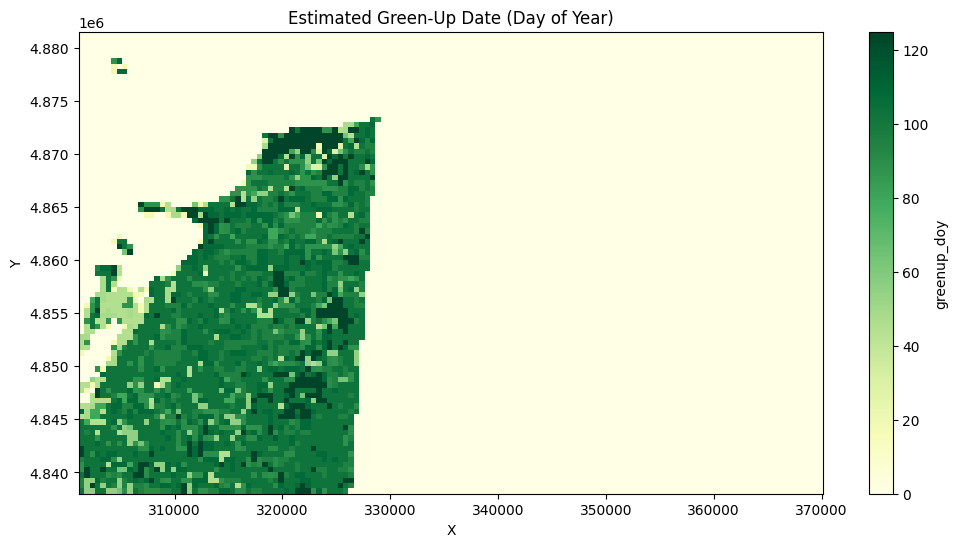

In [168]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = masked_evi.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = masked_evi.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Smooth using rolling mean
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = masked_evi.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year)
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year # we subtract 7 just to try and not overestimate
).astype("timedelta64[D]").astype("int16")

#7 day adjustment so as not to overestimate greenup
adjust_days = 7
days_since_jan1 = days_since_jan1 - adjust_days

#cut off all the negative values that were generated when it was null (0 -7)
days_since_jan1 = np.clip(days_since_jan1, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": masked_evi.y, "x": masked_evi.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [169]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")


Planting Date Stats (DOY Since Jan 1):
  Mean   : 96.5
  Median : 103.0
  Mode   : 103.0
  StdDev : 20.6
  Min    : 18.0
  Max    : 125.0


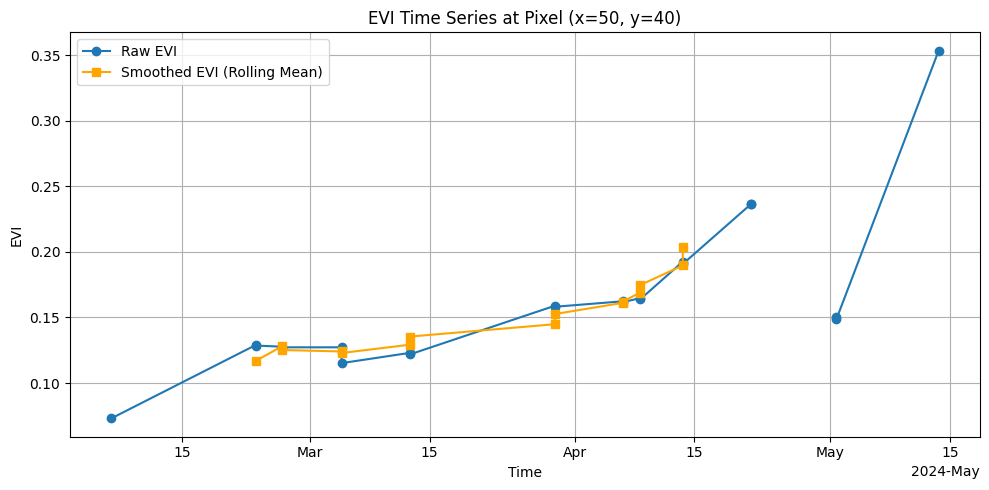

In [170]:
import matplotlib.pyplot as plt

# Step 1: Select a pixel by index (you can also use `.sel()` with coordinates)
ts = masked_evi.isel(x=50, y=40)

# Step 2: Smooth using rolling mean (e.g., window size = 3 time steps)
# Drop NaNs to avoid edge effects if necessary
ts_smooth = ts.rolling(time=5, center=True).mean()

# Step 3: Plot both raw and smoothed
plt.figure(figsize=(10, 5))
ts.plot(marker="o", label="Raw EVI")
ts_smooth.plot(marker="s", label="Smoothed EVI (Rolling Mean)", color="orange")
plt.title("EVI Time Series at Pixel (x=50, y=40)")
plt.xlabel("Time")
plt.ylabel("EVI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Masking on just wheat fields

In [241]:
import geopandas as gpd
import rioxarray

# Load wheat field boundaries for 2024
wheat_gdf = gpd.read_file("huron_winter_wheat_2024.geojson").to_crs("EPSG:32617")

# Attach CRS to EVI if not already present
evi.rio.write_crs("EPSG:32617", inplace=True)

# Clip EVI stack to just 2024 wheat field polygons
evi_clipped = evi.rio.clip(wheat_gdf.geometry.values, wheat_gdf.crs, drop=True)



##downsample the clipped evi

evi_downsampled = evi_clipped.coarsen(x=50, y=50, boundary="trim").mean()


In [243]:
import numpy as np
import xarray as xr

# How many time steps?
n_time = evi_downsampled.sizes["time"]

# Get time values (for metadata later)
time_values = evi_downsampled.time.values

# Create list to store each time slice
evi_list = []

# Loop through each time index
for t in range(n_time):
    print(f"Extracting time index {t+1}/{n_time}...")
    band = evi_downsampled.isel(time=t)
    arr = band.values  # this safely avoids Dask compute
    evi_list.append(arr)

# Stack into final 3D NumPy array (time, y, x)
evi_stack_2024_clipped = np.stack(evi_list, axis=0)
print("✅ EVI stack shape:", evi_stack_2024_clipped.shape)


Extracting time index 1/24...
Extracting time index 2/24...
Extracting time index 3/24...
Extracting time index 4/24...
Extracting time index 5/24...
Extracting time index 6/24...
Extracting time index 7/24...
Extracting time index 8/24...
Extracting time index 9/24...
Extracting time index 10/24...
Extracting time index 11/24...
Extracting time index 12/24...
Extracting time index 13/24...
Extracting time index 14/24...
Extracting time index 15/24...
Extracting time index 16/24...
Extracting time index 17/24...
Extracting time index 18/24...
Extracting time index 19/24...
Extracting time index 20/24...
Extracting time index 21/24...
Extracting time index 22/24...
Extracting time index 23/24...
Extracting time index 24/24...
✅ EVI stack shape: (24, 84, 137)


In [244]:
np.save('downsampled_2024_clipped.npy', evi_stack_2024_clipped)

In [245]:
evi_stack=np.load('downsampled_2024_clipped.npy')
time_values = evi_downsampled.time.values

In [246]:
# Get y and x coordinates
y_coords = evi_downsampled.y.values
x_coords = evi_downsampled.x.values

# Rebuild clean xarray object
evi_clean = xr.DataArray(
    data=evi_stack,
    dims=["time", "y", "x"],
    coords={"time": time_values, "y": y_coords, "x": x_coords},
    name="evi"
)

Text(0.5, 1.0, 'Number of Valid EVI Observations')

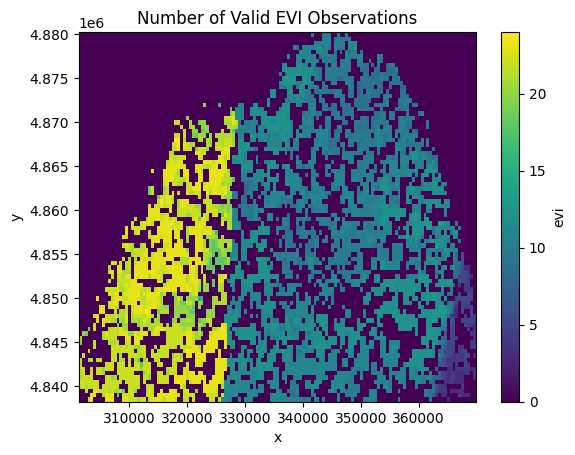

In [247]:
valid_counts = evi_clean.notnull().sum(dim="time")
valid_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Processing pixels: 100%|██████████| 11508/11508 [00:00<00:00, 16819.23it/s]


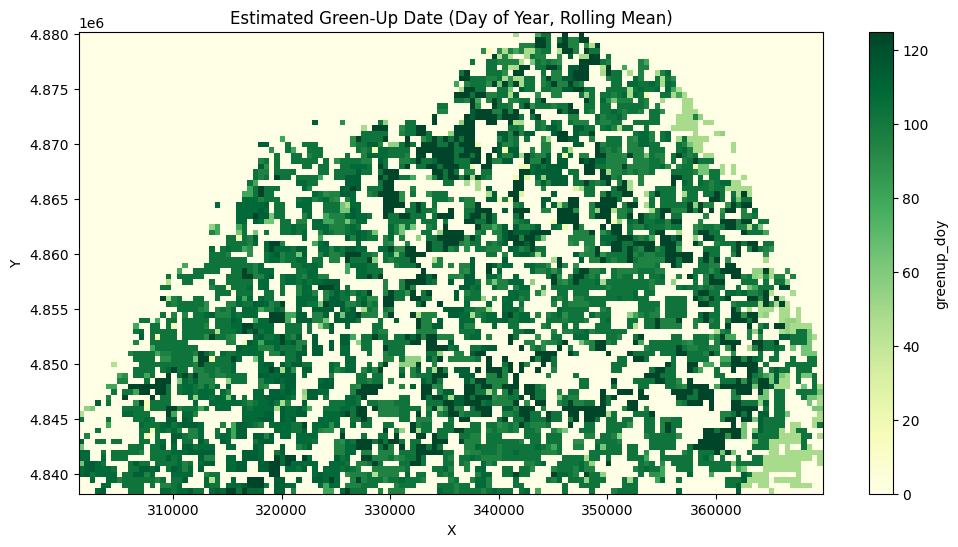

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = evi_clean.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = evi_clean.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Apply rolling mean smoothing with a window of 5
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = evi_clean.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year), with optional adjustment
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year
).astype("timedelta64[D]").astype("int16")

# Optional: adjust backward to approximate actual green-up onset
adjust_days = 7
days_since_jan1 = np.clip(days_since_jan1 - adjust_days, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": evi_clean.y, "x": evi_clean.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year, Rolling Mean)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [249]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")

Planting Date Stats (DOY Since Jan 1):
  Mean   : 102.1
  Median : 103.0
  Mode   : 103.0
  StdDev : 18.9
  Min    : 18.0
  Max    : 125.0


### Overlap

7.841661474767647
24
<class 'int'>


Text(0.5, 1.0, 'Number of Valid EVI Observations')

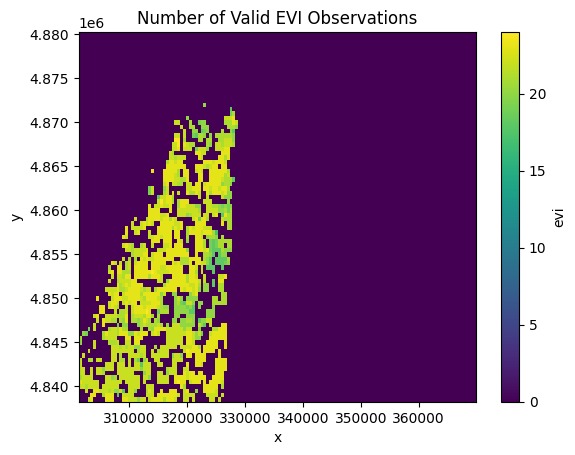

In [250]:
max_val = valid_counts.max().item()
std_dev=valid_counts.std().item()

print(std_dev)
print(max_val)              
print(type(max_val))        

# valid_index=(valid_counts==max_val)
valid_index=(valid_counts>=(max_val-std_dev))


# Expand valid_index to match dimensions of evi_clean
# This broadcasts it across all time steps
broadcast_mask = valid_index.expand_dims(time=evi_clean.time)

# Apply the mask
masked_evi = evi_clean.where(broadcast_mask, other=np.nan)


import matplotlib.pyplot as plt

# Plot a sample frame
masked_counts = masked_evi.notnull().sum(dim="time")
masked_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Rolling Mean instead

Processing pixels: 100%|██████████| 11508/11508 [00:00<00:00, 43099.01it/s]


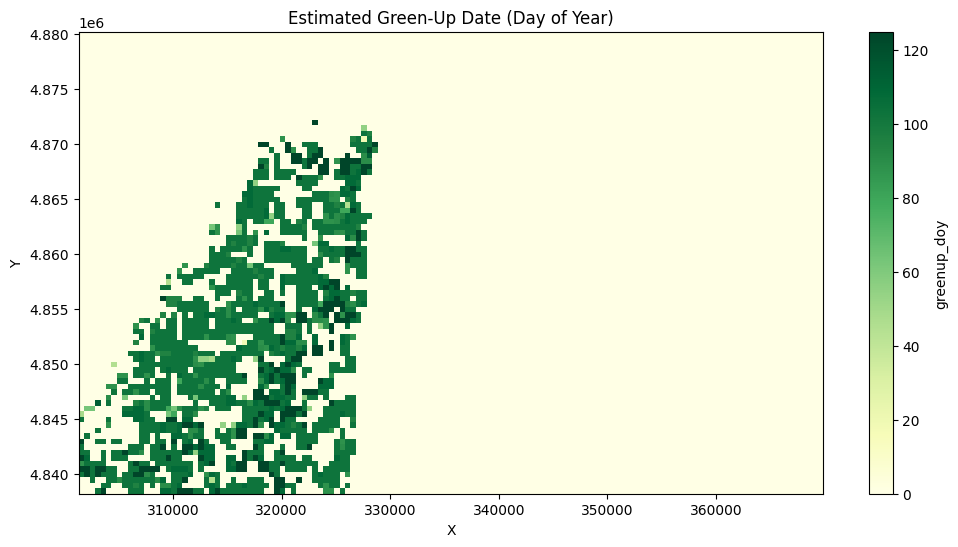

In [251]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = masked_evi.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = masked_evi.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Smooth using rolling mean
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = masked_evi.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year)
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year # we subtract 7 just to try and not overestimate
).astype("timedelta64[D]").astype("int16")

#7 day adjustment so as not to overestimate greenup
adjust_days = 7
days_since_jan1 = days_since_jan1 - adjust_days

#cut off all the negative values that were generated when it was null (0 -7)
days_since_jan1 = np.clip(days_since_jan1, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": masked_evi.y, "x": masked_evi.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [252]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")


Planting Date Stats (DOY Since Jan 1):
  Mean   : 103.9
  Median : 103.0
  Mode   : 103.0
  StdDev : 11.6
  Min    : 18.0
  Max    : 125.0


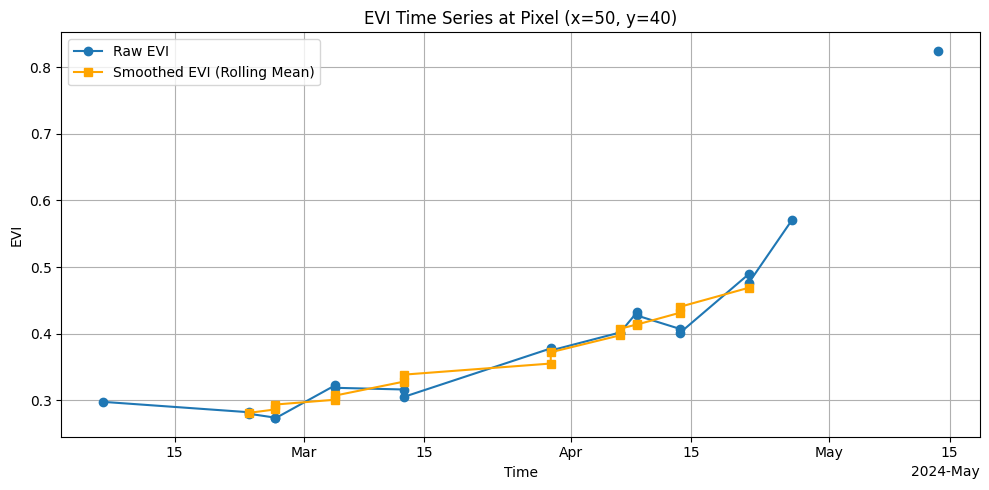

In [253]:
import matplotlib.pyplot as plt

# Step 1: Select a pixel by index (you can also use `.sel()` with coordinates)
ts = masked_evi.isel(x=50, y=40)

# Step 2: Smooth using rolling mean (e.g., window size = 3 time steps)
# Drop NaNs to avoid edge effects if necessary
ts_smooth = ts.rolling(time=5, center=True).mean()

# Step 3: Plot both raw and smoothed
plt.figure(figsize=(10, 5))
ts.plot(marker="o", label="Raw EVI")
ts_smooth.plot(marker="s", label="Smoothed EVI (Rolling Mean)", color="orange")
plt.title("EVI Time Series at Pixel (x=50, y=40)")
plt.xlabel("Time")
plt.ylabel("EVI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2023

### Load Sentinel2 Data 2023

In [1]:
import json
from shapely.geometry import shape
from pystac_client import Client

# Step 1: Load the GeoJSON file
with open("huron_county.geojson") as f:
    geojson = json.load(f)

# Step 2: Extract the geometry (assumes single feature)
geometry = shape(geojson["features"][0]["geometry"])

# Step 3: Use as `intersects` in your STAC search
catalog = Client.open("https://earth-search.aws.element84.com/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geometry,
    datetime="2023-01-01/2023-05-14",
    query={"eo:cloud_cover": {"lt": 40}},
    max_items=5000,
    
    #limit=5
)


In [2]:
# # Step 4: Collect and inspect results
items = list(search.items())
print(f"Found {len(items)} Sentinel-2 scenes for Huron County in June 2024")


print("Available bands in first scene:")
for asset_key in items[0].assets.keys():
    print(" -", asset_key)

Found 32 Sentinel-2 scenes for Huron County in June 2024
Available bands in first scene:
 - aot
 - blue
 - coastal
 - granule_metadata
 - green
 - nir
 - nir08
 - nir09
 - red
 - rededge1
 - rededge2
 - rededge3
 - scl
 - swir16
 - swir22
 - thumbnail
 - tileinfo_metadata
 - visual
 - wvp
 - aot-jp2
 - blue-jp2
 - coastal-jp2
 - green-jp2
 - nir-jp2
 - nir08-jp2
 - nir09-jp2
 - red-jp2
 - rededge1-jp2
 - rededge2-jp2
 - rededge3-jp2
 - scl-jp2
 - swir16-jp2
 - swir22-jp2
 - visual-jp2
 - wvp-jp2


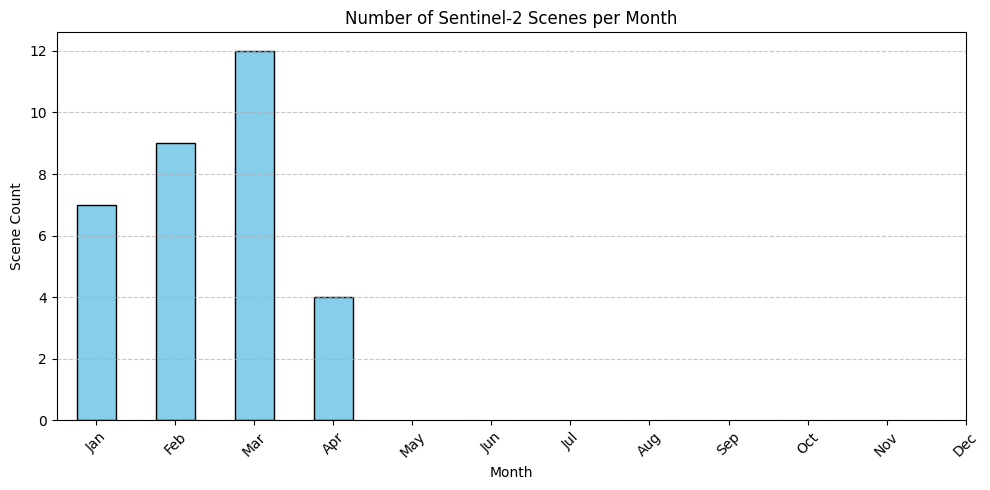

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract dates from STAC items
dates = [item.datetime.date() for item in items]
df = pd.DataFrame(dates, columns=["date"])

# Extract month and year
df["month"] = df["date"].apply(lambda d: d.month)
df["year"] = df["date"].apply(lambda d: d.year)

# Group by month and count scenes
monthly_counts = df.groupby("month").size()

# Plot
plt.figure(figsize=(10, 5))
monthly_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Sentinel-2 Scenes per Month")
plt.xlabel("Month")
plt.ylabel("Scene Count")
plt.xticks(ticks=range(0, 12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [4]:
tile_ids = set(item.id.split("_")[1] for item in items)
print("Tiles found in search:", tile_ids)


Tiles found in search: {'17TLJ', '16TGP'}


In [5]:
from pyproj import Transformer
from shapely.ops import transform

project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds


Ok, so we are going to get the 2024 wheat and then get break dormancy date from it. Then we will compare it to using the whole county and see if there is a difference.

In [6]:
import stackstac
# Stack with blue added
stack = stackstac.stack(
    items,
    assets=["blue", "red", "nir", "scl"],
    resolution=10,
    epsg=32617,
    dtype="float64",
    bounds=(minx, miny, maxx, maxy),
)


# Select bands
blue = stack.sel(band="blue")
red = stack.sel(band="red")
nir = stack.sel(band="nir")
scl = stack.sel(band="scl")

# # Cloud mask: 1 - saturated/defective, 3 - shadows, 8–10 - clouds, 11 - snow/ice
# cloud_mask = ~scl.isin([1, 3, 8, 9, 10, 11])

# # Sentinel-2 SCL land classes to keep (typically: 4 = vegetation, 5 = bare, etc.)
# # Exclude 6 (water), 0 (no data), and other unwanted classes if desired
# land_mask = scl.isin([4, 5])

# valid_mask = land_mask & cloud_mask


# Mask out water, cloud, shadows, snow, and no data
bad_scl = [0, 1, 3, 6, 7, 8, 9, 10, 11]  # adds: 0 = no data, 6 = water, 7 = unclassified
valid_mask = ~scl.isin(bad_scl)

# bad_scl = [0, 1, 3, 6, 9, 10, 11]  # Keep SCL=7 (unclassified) and 8 (medium clouds)
# valid_mask = ~scl.isin(bad_scl)



# Apply mask to bands
blue_masked = blue.where(valid_mask)
red_masked = red.where(valid_mask)
nir_masked = nir.where(valid_mask)

# EVI calculation
evi = 2.5 * (nir_masked - red_masked) / (
    nir_masked + 6 * red_masked - 7.5 * blue_masked + 1
)

# Add time dimension
evi = evi.assign_coords(time=stack.time)

# Optional: Clip to valid EVI range
evi = evi.clip(min=-1.0, max=1.0)


In [7]:
import geopandas as gpd
import rioxarray

# Load wheat field boundaries for 2024
wheat_gdf = gpd.read_file("huron_winter_wheat_2023.geojson").to_crs("EPSG:32617")

# Attach CRS to EVI if not already present
evi.rio.write_crs("EPSG:32617", inplace=True)

# Clip EVI stack to just 2024 wheat field polygons
evi_clipped = evi.rio.clip(wheat_gdf.geometry.values, wheat_gdf.crs, drop=True)

In [8]:
evi_clipped

<xarray.DataArray 'stackstac-0c50b2ee1cd2dad4a5d4c3d4f7738649' (time: 32,
                                                                y: 4290, x: 6916)> Size: 8GB
dask.array<getitem, shape=(32, 4290, 6916), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
    id                                       (time) <U24 3kB 'S2B_17TLJ_20230...
  * x                                        (x) float64 55kB 3.012e+05 ... 3...
  * y                                        (y) float64 34kB 4.881e+06 ... 4...
    s2:nodata_pixel_percentage               (time) object 256B 40.468273 ......
    s2:cloud_shadow_percentage               (time) object 256B 0 0 ... 0 0
    platform                                 (time) <U11 1kB 'sentinel-2b' .....
    ...                                       ...
    s2:medium_proba_clouds_percentage        (time) float64 256B 1.297 ... 0....
    mgrs:utm_zone                            (time) int64 256B 17 16 ... 17 16
    view:sun_azimuth                         (time) float64 256B 162.9 ... 149.4
    epsg                                     int64 8B 32617
  * time                                     (time) datetime64[ns] 256B 2023-...
    spatial_ref                              int64 8B 0

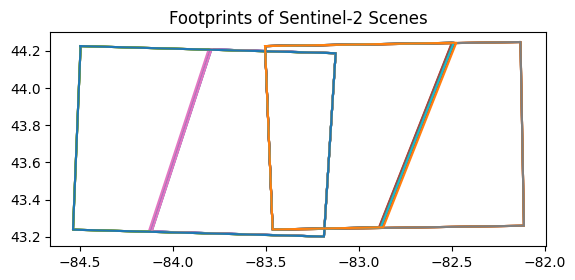

In [9]:
import matplotlib.pyplot as plt
from shapely.geometry import shape

geoms = [shape(item.geometry) for item in items]
for g in geoms:
    xs, ys = g.exterior.xy
    plt.plot(xs, ys)
plt.title("Footprints of Sentinel-2 Scenes")
plt.gca().set_aspect("equal")


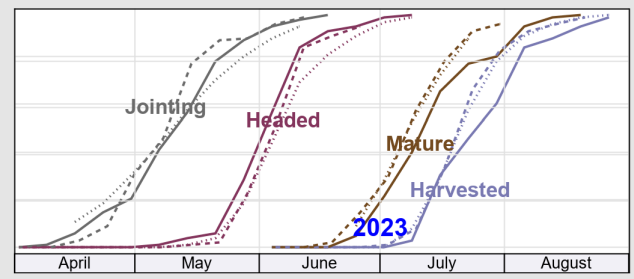

### Downsampled

In [10]:
evi_downsampled = evi.coarsen(x=50, y=50, boundary="trim").mean()

In [11]:
evi_downsampled

<xarray.DataArray 'stackstac-0c50b2ee1cd2dad4a5d4c3d4f7738649' (time: 32,
                                                                y: 87, x: 138)> Size: 3MB
dask.array<mean_agg-aggregate, shape=(32, 87, 138), dtype=float64, chunksize=(1, 20, 20), chunktype=numpy.ndarray>
Coordinates: (12/46)
    id                                       (time) <U24 3kB 'S2B_17TLJ_20230...
  * x                                        (x) float64 1kB 3.014e+05 ... 3....
  * y                                        (y) float64 696B 4.881e+06 ... 4...
    s2:nodata_pixel_percentage               (time) object 256B 40.468273 ......
    s2:cloud_shadow_percentage               (time) object 256B 0 0 ... 0 0
    platform                                 (time) <U11 1kB 'sentinel-2b' .....
    ...                                       ...
    s2:medium_proba_clouds_percentage        (time) float64 256B 1.297 ... 0....
    mgrs:utm_zone                            (time) int64 256B 17 16 ... 17 16
    view:sun_azimuth                         (time) float64 256B 162.9 ... 149.4
    epsg                                     int64 8B 32617
  * time                                     (time) datetime64[ns] 256B 2023-...
    spatial_ref                              int64 8B 0

In [ ]:
import numpy as np
import xarray as xr

# How many time steps?
n_time = evi_downsampled.sizes["time"]

# Get time values (for metadata later)
time_values = evi_downsampled.time.values

# Create list to store each time slice
evi_list = []

# Loop through each time index
for t in range(n_time):
    print(f"Extracting time index {t+1}/{n_time}...")
    band = evi_downsampled.isel(time=t)
    arr = band.values  # this safely avoids Dask compute
    evi_list.append(arr)

# Stack into final 3D NumPy array (time, y, x)
evi_stack_2023 = np.stack(evi_list, axis=0)
print("✅ EVI stack shape:", evi_stack_2023.shape)


Extracting time index 1/32...
Extracting time index 2/32...
Extracting time index 3/32...
Extracting time index 4/32...
Extracting time index 5/32...
Extracting time index 6/32...
Extracting time index 7/32...
Extracting time index 8/32...
Extracting time index 9/32...
Extracting time index 10/32...
Extracting time index 11/32...
Extracting time index 12/32...
Extracting time index 13/32...
Extracting time index 14/32...
Extracting time index 15/32...
Extracting time index 16/32...
Extracting time index 17/32...
Extracting time index 18/32...
Extracting time index 19/32...
Extracting time index 20/32...
Extracting time index 21/32...
Extracting time index 22/32...
Extracting time index 23/32...
Extracting time index 24/32...
Extracting time index 25/32...
Extracting time index 26/32...
Extracting time index 27/32...
Extracting time index 28/32...
Extracting time index 29/32...
Extracting time index 30/32...
Extracting time index 31/32...
Extracting time index 32/32...
✅ EVI stack shape

In [ ]:
np.save('downsampled_2023.npy', evi_stack_2023)

In [182]:
evi_stack=np.load('downsampled_2023.npy')
time_values = evi_downsampled.time.values

In [183]:
# Get y and x coordinates
y_coords = evi_downsampled.y.values
x_coords = evi_downsampled.x.values

# Rebuild clean xarray object
evi_clean = xr.DataArray(
    data=evi_stack,
    dims=["time", "y", "x"],
    coords={"time": time_values, "y": y_coords, "x": x_coords},
    name="evi"
)





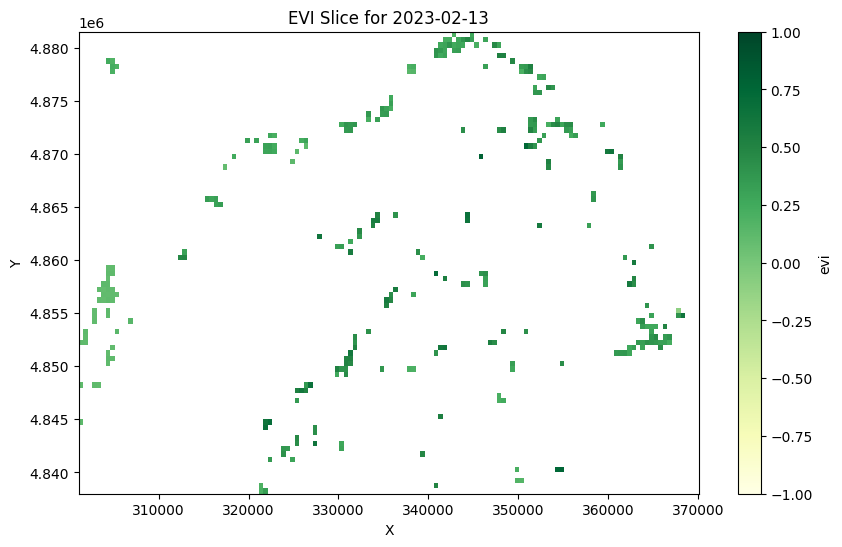

In [184]:
import matplotlib.pyplot as plt

# Choose a time index (e.g. 0 for first date, or 5 for later)
evi_clean.isel(time=0).plot(
    cmap="YlGn",
    vmin=-1, vmax=1,
    figsize=(10, 6)
)
plt.title(f"EVI Slice for {str(evi_clean.time.values[5])[:10]}")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Text(0.5, 1.0, 'Number of Valid EVI Observations')

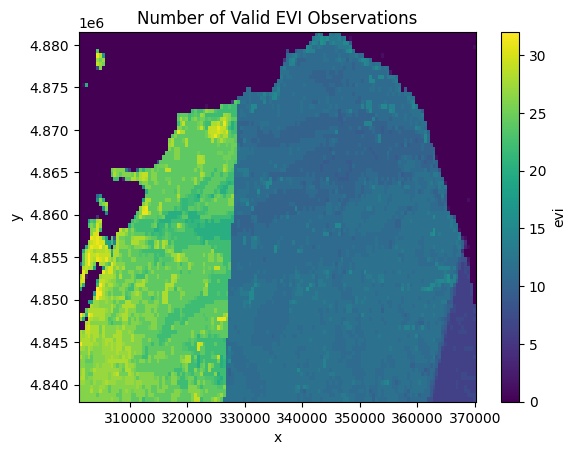

In [185]:
valid_counts = evi_clean.notnull().sum(dim="time")
valid_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Rolling Mean with the whole down-sampled EVI

Processing pixels:   0%|          | 0/12006 [00:00<?, ?it/s]

Processing pixels: 100%|██████████| 12006/12006 [00:01<00:00, 6963.03it/s]


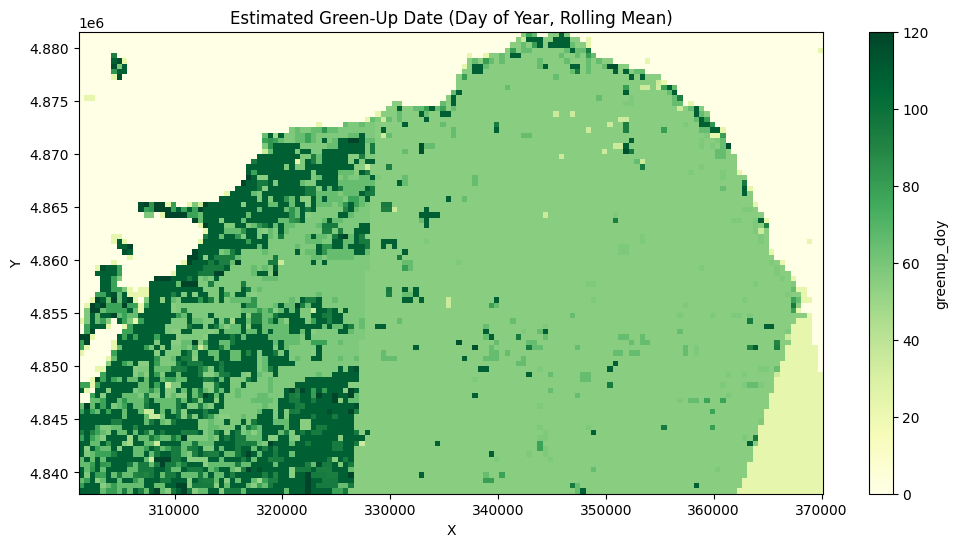

In [186]:
# time_length = evi_clean.sizes["time"]
# window_size=time_length/4.9
# window_size=np.round(window_size)




import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = evi_clean.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = evi_clean.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Apply rolling mean smoothing with a window of 5
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = evi_clean.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year), with optional adjustment
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year
).astype("timedelta64[D]").astype("int16")

# Optional: adjust backward to approximate actual green-up onset
adjust_days = 7
days_since_jan1 = np.clip(days_since_jan1 - adjust_days, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": evi_clean.y, "x": evi_clean.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year, Rolling Mean)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [187]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")


Planting Date Stats (DOY Since Jan 1):
  Mean   : 64.0
  Median : 55.0
  Mode   : 55.0
  StdDev : 21.5
  Min    : 23.0
  Max    : 120.0


### Overlap

8.732829381952756
32
<class 'int'>


Text(0.5, 1.0, 'Number of Valid EVI Observations')

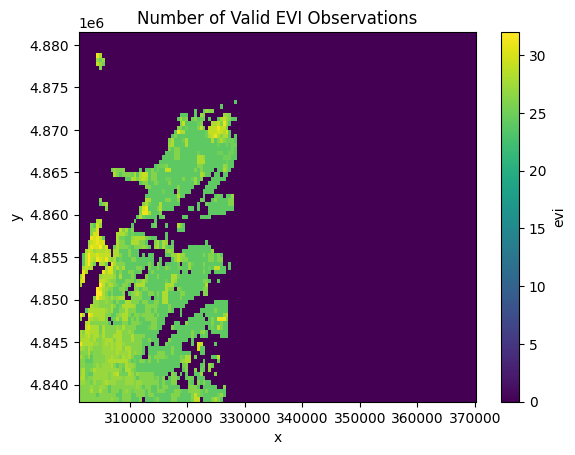

In [188]:
max_val = valid_counts.max().item()
std_dev=valid_counts.std().item()

print(std_dev)
print(max_val)              
print(type(max_val))        

# valid_index=(valid_counts==max_val)
valid_index=(valid_counts>=(max_val-std_dev))


# Expand valid_index to match dimensions of evi_clean
# This broadcasts it across all time steps
broadcast_mask = valid_index.expand_dims(time=evi_clean.time)

# Apply the mask
masked_evi = evi_clean.where(broadcast_mask, other=np.nan)


import matplotlib.pyplot as plt

# Plot a sample frame
masked_counts = masked_evi.notnull().sum(dim="time")
masked_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Rolling Mean instead

Processing pixels: 100%|██████████| 12006/12006 [00:00<00:00, 24818.22it/s]


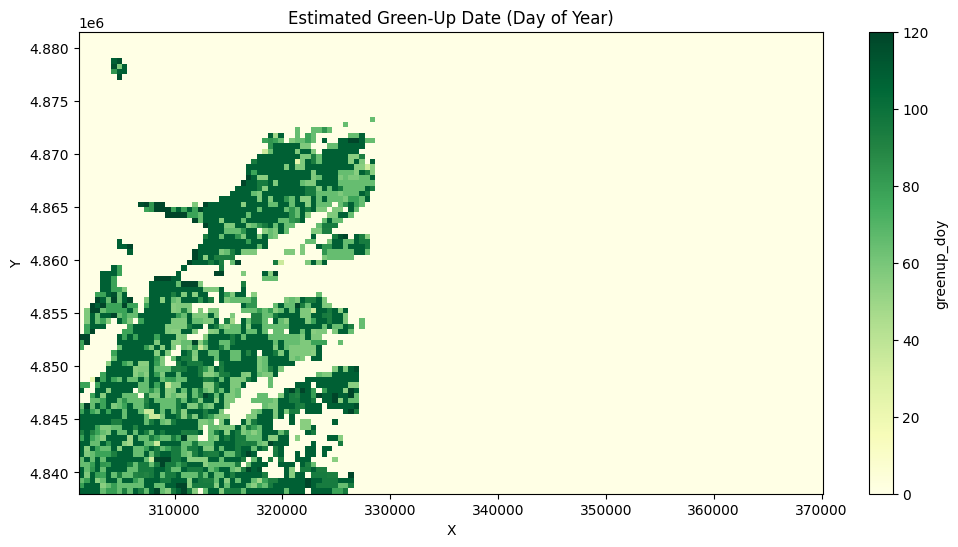

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = masked_evi.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = masked_evi.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Smooth using rolling mean
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = masked_evi.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year)
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year # we subtract 7 just to try and not overestimate
).astype("timedelta64[D]").astype("int16")

#7 day adjustment so as not to overestimate greenup
adjust_days = 7
days_since_jan1 = days_since_jan1 - adjust_days

#cut off all the negative values that were generated when it was null (0 -7)
days_since_jan1 = np.clip(days_since_jan1, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": masked_evi.y, "x": masked_evi.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [197]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")


Planting Date Stats (DOY Since Jan 1):
  Mean   : 89.5
  Median : 108.0
  Mode   : 108.0
  StdDev : 22.1
  Min    : 23.0
  Max    : 120.0


### Masking on just wheat fields

In [12]:
import geopandas as gpd
import rioxarray

# Load wheat field boundaries for 2024
wheat_gdf = gpd.read_file("huron_winter_wheat_2023.geojson").to_crs("EPSG:32617")

# Attach CRS to EVI if not already present
evi.rio.write_crs("EPSG:32617", inplace=True)

# Clip EVI stack to just 2024 wheat field polygons
evi_clipped = evi.rio.clip(wheat_gdf.geometry.values, wheat_gdf.crs, drop=True)



##downsample the clipped evi

evi_downsampled = evi_clipped.coarsen(x=50, y=50, boundary="trim").mean()


In [13]:
import numpy as np
import xarray as xr

# How many time steps?
n_time = evi_downsampled.sizes["time"]

# Get time values (for metadata later)
time_values = evi_downsampled.time.values

# Create list to store each time slice
evi_list = []

# Loop through each time index
for t in range(n_time):
    print(f"Extracting time index {t+1}/{n_time}...")
    band = evi_downsampled.isel(time=t)
    arr = band.values  # this safely avoids Dask compute
    evi_list.append(arr)

# Stack into final 3D NumPy array (time, y, x)
evi_stack_2023_clipped = np.stack(evi_list, axis=0)
print("✅ EVI stack shape:", evi_stack_2023_clipped.shape)


Extracting time index 1/32...
Extracting time index 2/32...
Extracting time index 3/32...
Extracting time index 4/32...
Extracting time index 5/32...
Extracting time index 6/32...
Extracting time index 7/32...
Extracting time index 8/32...
Extracting time index 9/32...
Extracting time index 10/32...
Extracting time index 11/32...
Extracting time index 12/32...
Extracting time index 13/32...
Extracting time index 14/32...
Extracting time index 15/32...
Extracting time index 16/32...
Extracting time index 17/32...
Extracting time index 18/32...
Extracting time index 19/32...
Extracting time index 20/32...
Extracting time index 21/32...
Extracting time index 22/32...
Extracting time index 23/32...


c:\Users\Porter\anaconda3\envs\default_dev\Lib\site-packages\dask\_task_spec.py:764: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


Extracting time index 24/32...
Extracting time index 25/32...
Extracting time index 26/32...
Extracting time index 27/32...
Extracting time index 28/32...
Extracting time index 29/32...
Extracting time index 30/32...
Extracting time index 31/32...
Extracting time index 32/32...
✅ EVI stack shape: (32, 85, 138)


In [14]:
np.save('downsampled_2023_clipped.npy', evi_stack_2023_clipped)

In [15]:
evi_stack=np.load('downsampled_2023_clipped.npy')
time_values = evi_downsampled.time.values

In [16]:
# Get y and x coordinates
y_coords = evi_downsampled.y.values
x_coords = evi_downsampled.x.values

# Rebuild clean xarray object
evi_clean = xr.DataArray(
    data=evi_stack,
    dims=["time", "y", "x"],
    coords={"time": time_values, "y": y_coords, "x": x_coords},
    name="evi"
)

Text(0.5, 1.0, 'Number of Valid EVI Observations')

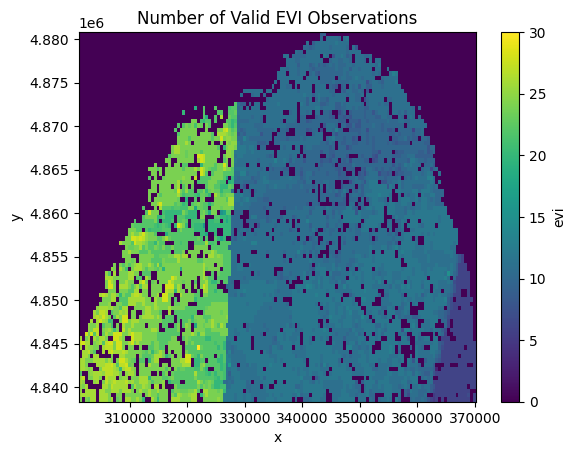

In [17]:
valid_counts = evi_clean.notnull().sum(dim="time")
valid_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Processing pixels: 100%|██████████| 11730/11730 [00:01<00:00, 9361.25it/s]


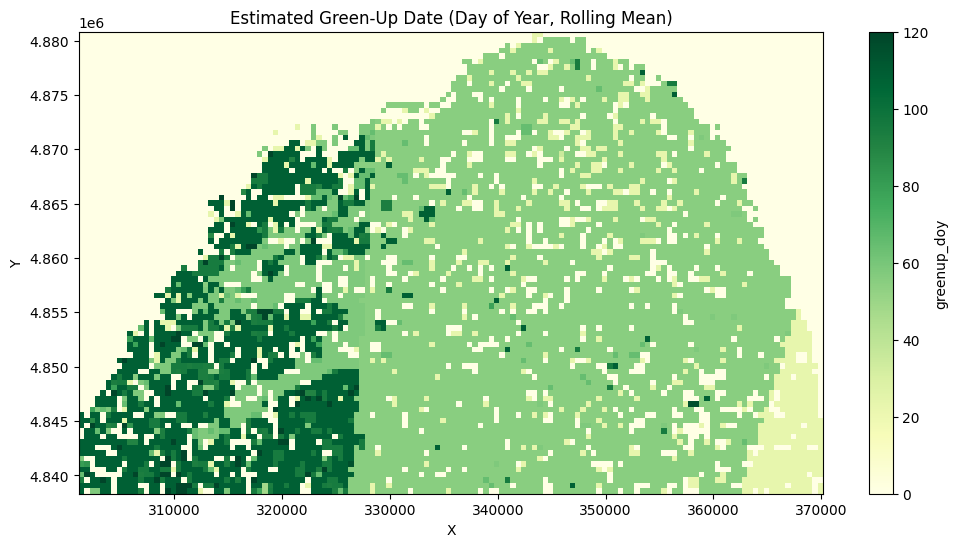

In [24]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = evi_clean.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = evi_clean.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Apply rolling mean smoothing with a window of 5
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = evi_clean.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year), with optional adjustment
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year
).astype("timedelta64[D]").astype("int16")

# Optional: adjust backward to approximate actual green-up onset
adjust_days = 7
days_since_jan1 = np.clip(days_since_jan1 - adjust_days, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": evi_clean.y, "x": evi_clean.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year, Rolling Mean)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [25]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")

Planting Date Stats (DOY Since Jan 1):
  Mean   : 63.0
  Median : 55.0
  Mode   : 55.0
  StdDev : 24.2
  Min    : 23.0
  Max    : 120.0


### Overlap

8.44468454717976
30
<class 'int'>


Text(0.5, 1.0, 'Number of Valid EVI Observations')

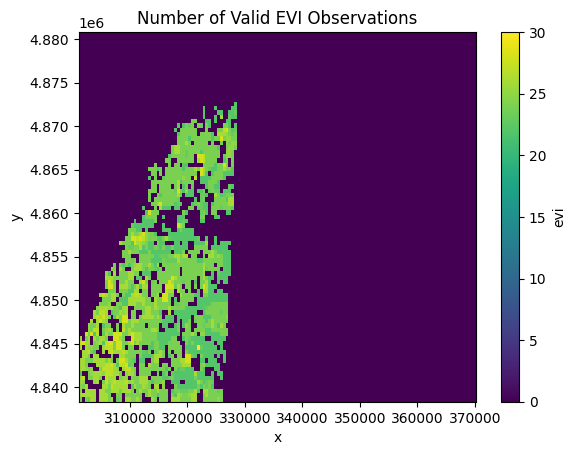

In [26]:
max_val = valid_counts.max().item()
std_dev=valid_counts.std().item()

print(std_dev)
print(max_val)              
print(type(max_val))        

# valid_index=(valid_counts==max_val)
valid_index=(valid_counts>=(max_val-std_dev))


# Expand valid_index to match dimensions of evi_clean
# This broadcasts it across all time steps
broadcast_mask = valid_index.expand_dims(time=evi_clean.time)

# Apply the mask
masked_evi = evi_clean.where(broadcast_mask, other=np.nan)


import matplotlib.pyplot as plt

# Plot a sample frame
masked_counts = masked_evi.notnull().sum(dim="time")
masked_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Rolling Mean instead

Processing pixels: 100%|██████████| 11730/11730 [00:00<00:00, 36519.50it/s]


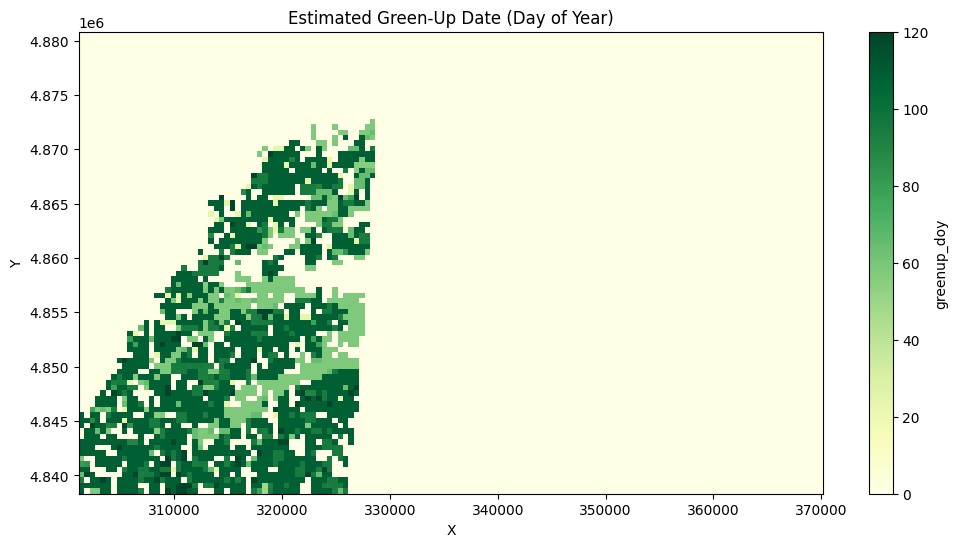

In [27]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = masked_evi.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = masked_evi.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Smooth using rolling mean
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = masked_evi.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year)
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year # we subtract 7 just to try and not overestimate
).astype("timedelta64[D]").astype("int16")

#7 day adjustment so as not to overestimate greenup
adjust_days = 7
days_since_jan1 = days_since_jan1 - adjust_days

#cut off all the negative values that were generated when it was null (0 -7)
days_since_jan1 = np.clip(days_since_jan1, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": masked_evi.y, "x": masked_evi.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [28]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")


Planting Date Stats (DOY Since Jan 1):
  Mean   : 93.7
  Median : 108.0
  Mode   : 108.0
  StdDev : 23.1
  Min    : 23.0
  Max    : 120.0


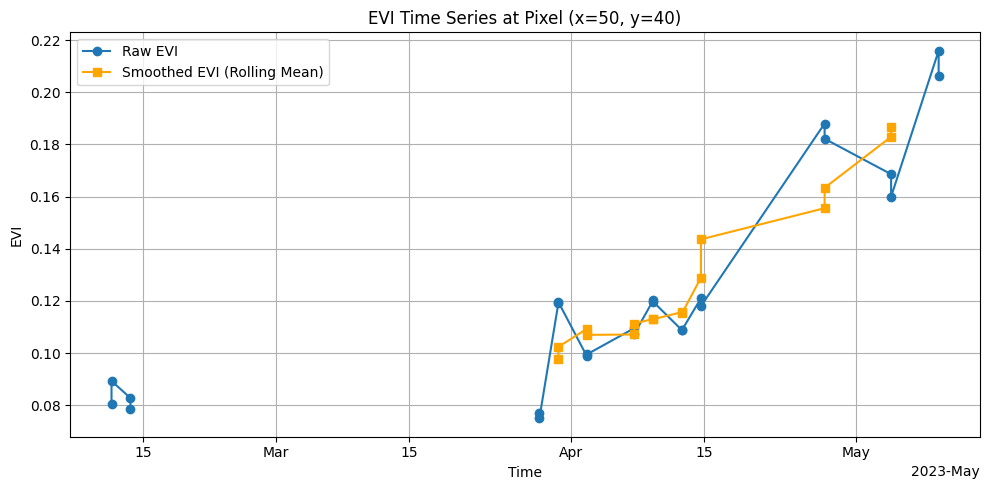

In [23]:
import matplotlib.pyplot as plt

# Step 1: Select a pixel by index (you can also use `.sel()` with coordinates)
ts = masked_evi.isel(x=50, y=40)

# Step 2: Smooth using rolling mean (e.g., window size = 3 time steps)
# Drop NaNs to avoid edge effects if necessary
ts_smooth = ts.rolling(time=5, center=True).mean()

# Step 3: Plot both raw and smoothed
plt.figure(figsize=(10, 5))
ts.plot(marker="o", label="Raw EVI")
ts_smooth.plot(marker="s", label="Smoothed EVI (Rolling Mean)", color="orange")
plt.title("EVI Time Series at Pixel (x=50, y=40)")
plt.xlabel("Time")
plt.ylabel("EVI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2025

### Load Sentinel2 Data 2025

In [206]:
import json
from shapely.geometry import shape
from pystac_client import Client

# Step 1: Load the GeoJSON file
with open("huron_county.geojson") as f:
    geojson = json.load(f)

# Step 2: Extract the geometry (assumes single feature)
geometry = shape(geojson["features"][0]["geometry"])

# Step 3: Use as `intersects` in your STAC search
catalog = Client.open("https://earth-search.aws.element84.com/v1")

search = catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=geometry,
    datetime="2025-01-01/2025-05-27",
    query={"eo:cloud_cover": {"lt": 40}},
    max_items=5000,
    
    #limit=5
)


In [207]:
# # Step 4: Collect and inspect results
items = list(search.items())
print(f"Found {len(items)} Sentinel-2 scenes for Huron County in June 2024")


print("Available bands in first scene:")
for asset_key in items[0].assets.keys():
    print(" -", asset_key)

Found 41 Sentinel-2 scenes for Huron County in June 2024
Available bands in first scene:
 - aot
 - blue
 - cloud
 - coastal
 - granule_metadata
 - green
 - nir
 - nir08
 - nir09
 - product_metadata
 - red
 - rededge1
 - rededge2
 - rededge3
 - scl
 - snow
 - swir16
 - swir22
 - tileinfo_metadata
 - visual
 - wvp
 - thumbnail
 - aot-jp2
 - blue-jp2
 - coastal-jp2
 - green-jp2
 - nir-jp2
 - nir08-jp2
 - nir09-jp2
 - red-jp2
 - rededge1-jp2
 - rededge2-jp2
 - rededge3-jp2
 - scl-jp2
 - swir16-jp2
 - swir22-jp2
 - visual-jp2
 - wvp-jp2


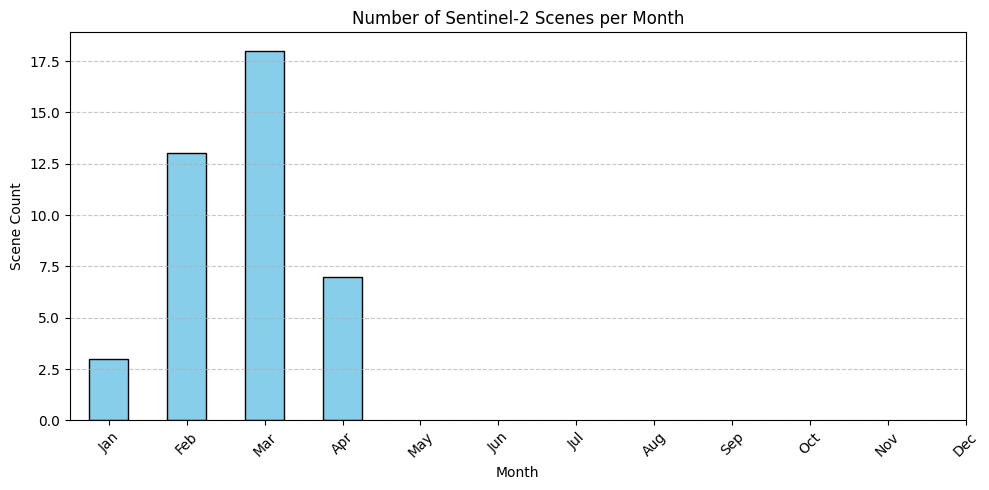

In [208]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract dates from STAC items
dates = [item.datetime.date() for item in items]
df = pd.DataFrame(dates, columns=["date"])

# Extract month and year
df["month"] = df["date"].apply(lambda d: d.month)
df["year"] = df["date"].apply(lambda d: d.year)

# Group by month and count scenes
monthly_counts = df.groupby("month").size()

# Plot
plt.figure(figsize=(10, 5))
monthly_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Number of Sentinel-2 Scenes per Month")
plt.xlabel("Month")
plt.ylabel("Scene Count")
plt.xticks(ticks=range(0, 12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [209]:
tile_ids = set(item.id.split("_")[1] for item in items)
print("Tiles found in search:", tile_ids)


Tiles found in search: {'17TLJ', '16TGP'}


In [210]:
from pyproj import Transformer
from shapely.ops import transform

project = Transformer.from_crs("epsg:4326", "epsg:32617", always_xy=True).transform
geometry_utm = transform(project, geometry)
minx, miny, maxx, maxy = geometry_utm.bounds


In [211]:
import stackstac
# Stack with blue added
stack = stackstac.stack(
    items,
    assets=["blue", "red", "nir", "scl"],
    resolution=10,
    epsg=32617,
    dtype="float64",
    bounds=(minx, miny, maxx, maxy),
)


# Select bands
blue = stack.sel(band="blue")
red = stack.sel(band="red")
nir = stack.sel(band="nir")
scl = stack.sel(band="scl")

# # Cloud mask: 1 - saturated/defective, 3 - shadows, 8–10 - clouds, 11 - snow/ice
# cloud_mask = ~scl.isin([1, 3, 8, 9, 10, 11])

# # Sentinel-2 SCL land classes to keep (typically: 4 = vegetation, 5 = bare, etc.)
# # Exclude 6 (water), 0 (no data), and other unwanted classes if desired
# land_mask = scl.isin([4, 5])

# valid_mask = land_mask & cloud_mask


# Mask out water, cloud, shadows, snow, and no data
bad_scl = [0, 1, 3, 6, 7, 8, 9, 10, 11]  # adds: 0 = no data, 6 = water, 7 = unclassified
valid_mask = ~scl.isin(bad_scl)

# bad_scl = [0, 1, 3, 6, 9, 10, 11]  # Keep SCL=7 (unclassified) and 8 (medium clouds)
# valid_mask = ~scl.isin(bad_scl)



# Apply mask to bands
blue_masked = blue.where(valid_mask)
red_masked = red.where(valid_mask)
nir_masked = nir.where(valid_mask)

# EVI calculation
evi = 2.5 * (nir_masked - red_masked) / (
    nir_masked + 6 * red_masked - 7.5 * blue_masked + 1
)

# Add time dimension
evi = evi.assign_coords(time=stack.time)

# Optional: Clip to valid EVI range
evi = evi.clip(min=-1.0, max=1.0)


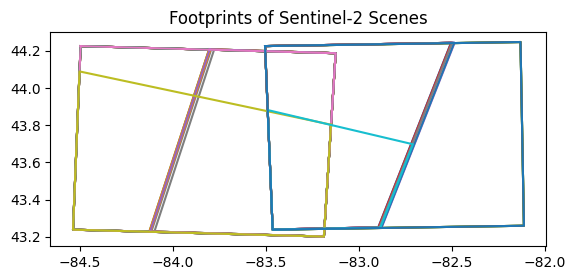

In [212]:
import matplotlib.pyplot as plt
from shapely.geometry import shape

geoms = [shape(item.geometry) for item in items]
for g in geoms:
    xs, ys = g.exterior.xy
    plt.plot(xs, ys)
plt.title("Footprints of Sentinel-2 Scenes")
plt.gca().set_aspect("equal")


### Downsampled

In [213]:
evi_downsampled = evi.coarsen(x=50, y=50, boundary="trim").mean()

In [214]:
evi_downsampled

<xarray.DataArray 'stackstac-61940a1a3df358ef1dc9a1dceea79147' (time: 41,
                                                                y: 87, x: 138)> Size: 4MB
dask.array<mean_agg-aggregate, shape=(41, 87, 138), dtype=float64, chunksize=(1, 20, 20), chunktype=numpy.ndarray>
Coordinates: (12/47)
    id                                       (time) <U24 4kB 'S2B_17TLJ_20250...
  * x                                        (x) float64 1kB 3.014e+05 ... 3....
  * y                                        (y) float64 696B 4.881e+06 ... 4...
    s2:high_proba_clouds_percentage          (time) float64 328B 4.818 ... 0....
    s2:medium_proba_clouds_percentage        (time) float64 328B 4.102 ... 0.601
    s2:product_uri                           (time) <U65 11kB 'S2B_MSIL2A_202...
    ...                                       ...
    s2:tile_id                               (time) <U62 10kB 'S2B_OPER_MSI_L...
    earthsearch:payload_id                   (time) <U74 12kB 'roda-sentinel2...
    s2:degraded_msi_data_percentage          (time) object 328B 0.0215 ... 0....
    s2:not_vegetated_percentage              (time) float64 328B 0.6503 ... 2...
    epsg                                     int64 8B 32617
  * time                                     (time) datetime64[ns] 328B 2025-...

In [215]:
import numpy as np
import xarray as xr

# How many time steps?
n_time = evi_downsampled.sizes["time"]

# Get time values (for metadata later)
time_values = evi_downsampled.time.values

# Create list to store each time slice
evi_list = []

# Loop through each time index
for t in range(n_time):
    print(f"Extracting time index {t+1}/{n_time}...")
    band = evi_downsampled.isel(time=t)
    arr = band.values  # this safely avoids Dask compute
    evi_list.append(arr)

# Stack into final 3D NumPy array (time, y, x)
evi_stack_2025 = np.stack(evi_list, axis=0)
print("✅ EVI stack shape:", evi_stack_2025.shape)


Extracting time index 1/41...
Extracting time index 2/41...
Extracting time index 3/41...
Extracting time index 4/41...
Extracting time index 5/41...
Extracting time index 6/41...
Extracting time index 7/41...
Extracting time index 8/41...
Extracting time index 9/41...
Extracting time index 10/41...
Extracting time index 11/41...
Extracting time index 12/41...
Extracting time index 13/41...
Extracting time index 14/41...
Extracting time index 15/41...
Extracting time index 16/41...
Extracting time index 17/41...
Extracting time index 18/41...
Extracting time index 19/41...
Extracting time index 20/41...
Extracting time index 21/41...
Extracting time index 22/41...
Extracting time index 23/41...
Extracting time index 24/41...
Extracting time index 25/41...
Extracting time index 26/41...
Extracting time index 27/41...
Extracting time index 28/41...
Extracting time index 29/41...
Extracting time index 30/41...
Extracting time index 31/41...
Extracting time index 32/41...
Extracting time i

In [216]:
np.save('downsampled_2025.npy', evi_stack_2025)

In [217]:
evi_stack=np.load('downsampled_2025.npy')
time_values = evi_downsampled.time.values

In [218]:
# Get y and x coordinates
y_coords = evi_downsampled.y.values
x_coords = evi_downsampled.x.values

# Rebuild clean xarray object
evi_clean = xr.DataArray(
    data=evi_stack,
    dims=["time", "y", "x"],
    coords={"time": time_values, "y": y_coords, "x": x_coords},
    name="evi"
)

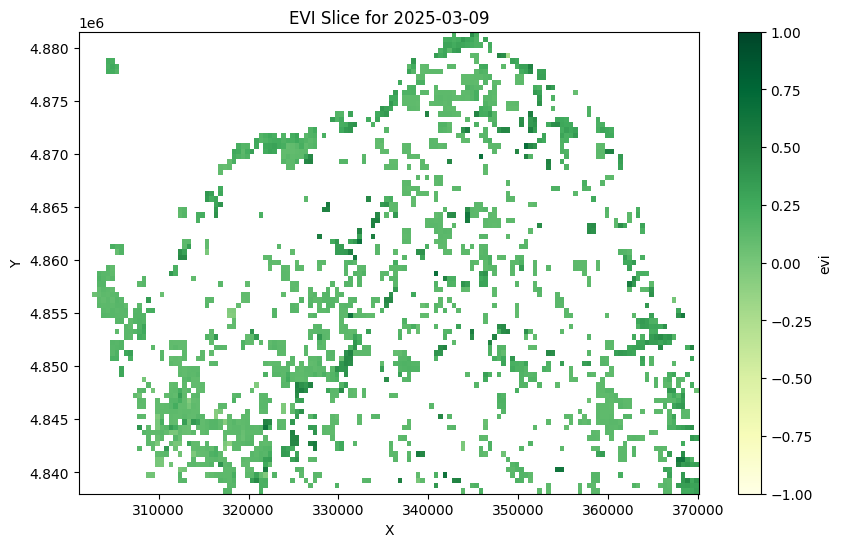

In [219]:
import matplotlib.pyplot as plt

# Choose a time index (e.g. 0 for first date, or 5 for later)
evi_clean.isel(time=0).plot(
    cmap="YlGn",
    vmin=-1, vmax=1,
    figsize=(10, 6)
)
plt.title(f"EVI Slice for {str(evi_clean.time.values[5])[:10]}")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Text(0.5, 1.0, 'Number of Valid EVI Observations')

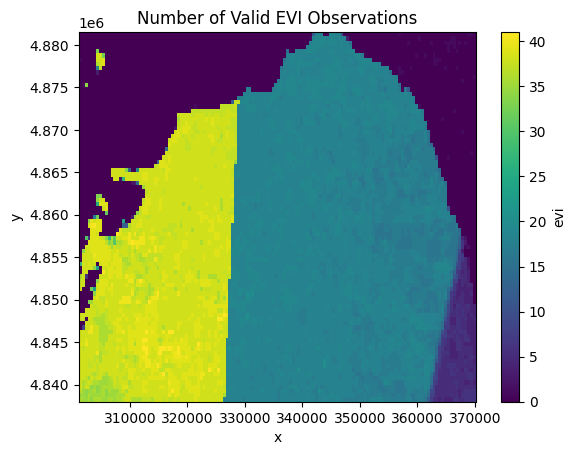

In [220]:
valid_counts = evi_clean.notnull().sum(dim="time")
valid_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Rolling Mean with the whole down-sampled EVI

Processing pixels:   0%|          | 0/12006 [00:00<?, ?it/s]

Processing pixels: 100%|██████████| 12006/12006 [00:03<00:00, 3496.04it/s]


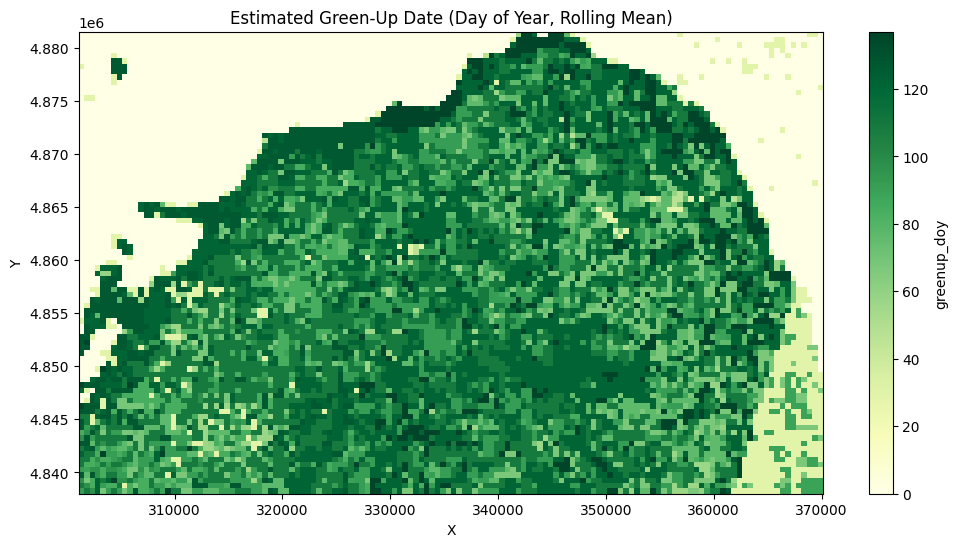

In [221]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = evi_clean.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = evi_clean.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Apply rolling mean smoothing with a window of 5
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = evi_clean.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year), with optional adjustment
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year
).astype("timedelta64[D]").astype("int16")

# Optional: adjust backward to approximate actual green-up onset
adjust_days = 7
days_since_jan1 = np.clip(days_since_jan1 - adjust_days, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": evi_clean.y, "x": evi_clean.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year, Rolling Mean)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [222]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")


Planting Date Stats (DOY Since Jan 1):
  Mean   : 102.1
  Median : 109.0
  Mode   : 122.0
  StdDev : 26.6
  Min    : 29.0
  Max    : 137.0


### Overlap

13.484080942208639
41
<class 'int'>


Text(0.5, 1.0, 'Number of Valid EVI Observations')

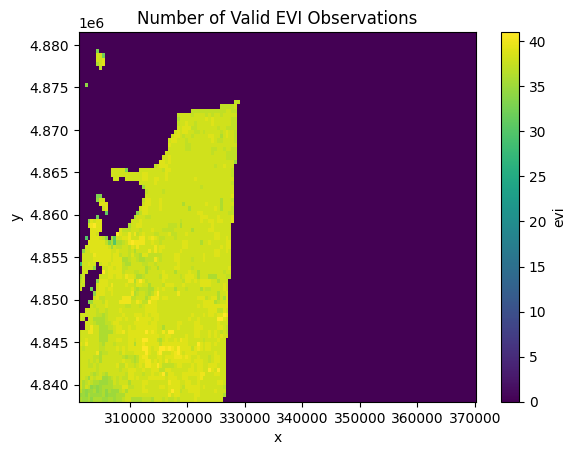

In [223]:
max_val = valid_counts.max().item()
std_dev=valid_counts.std().item()

print(std_dev)
print(max_val)              
print(type(max_val))        

# valid_index=(valid_counts==max_val)
valid_index=(valid_counts>=(max_val-std_dev))


# Expand valid_index to match dimensions of evi_clean
# This broadcasts it across all time steps
broadcast_mask = valid_index.expand_dims(time=evi_clean.time)

# Apply the mask
masked_evi = evi_clean.where(broadcast_mask, other=np.nan)


import matplotlib.pyplot as plt

# Plot a sample frame
masked_counts = masked_evi.notnull().sum(dim="time")
masked_counts.plot(cmap="viridis")
plt.title("Number of Valid EVI Observations")

Rolling Mean instead

Processing pixels: 100%|██████████| 12006/12006 [00:00<00:00, 21226.20it/s]


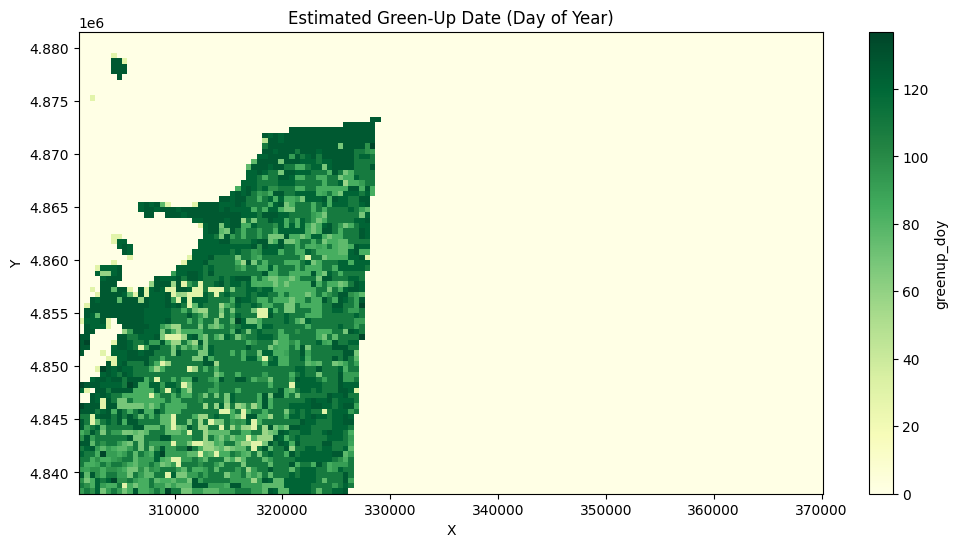

In [224]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Step 1: Unpack shape
time_len, y_len, x_len = masked_evi.shape

# Step 2: Flatten spatial dims for easier iteration
evi_flat = masked_evi.values.reshape(time_len, -1)  # shape: (time, y*x)

# Step 3: Allocate output for green-up indices
greenup_indices = np.full(evi_flat.shape[1], np.nan)

# Step 4: Loop through each pixel with progress bar
for i in tqdm(range(evi_flat.shape[1]), desc="Processing pixels"):
    evi_ts = evi_flat[:, i]
    if np.all(np.isnan(evi_ts)):
        continue
    try:
        # Smooth using rolling mean
        ts_series = pd.Series(evi_ts)
        smoothed = ts_series.rolling(window=7, center=True, min_periods=1).mean().values

        # First derivative
        first_deriv = np.gradient(smoothed)

        # Detect green-up: index of max first derivative
        greenup_indices[i] = np.argmax(first_deriv)
    except:
        pass  # leave as NaN

# Step 5: Reshape back to 2D
greenup_index_2d = greenup_indices.reshape(y_len, x_len)

# Step 6: Mask invalid
time_values = masked_evi.time.values
valid_mask = (
    (~np.isnan(greenup_index_2d)) &
    (greenup_index_2d >= 0) &
    (greenup_index_2d < len(time_values))
)

# Step 7: Convert index to dates
greenup_dates = np.full((y_len, x_len), np.datetime64("NaT"), dtype="datetime64[D]")
greenup_dates[valid_mask] = time_values[greenup_index_2d[valid_mask].astype(int)]

# Step 8: Convert to DOY (day of year)
start_of_year = np.datetime64(pd.Timestamp(time_values[0]).replace(month=1, day=1))
days_since_jan1 = (
    greenup_dates - start_of_year # we subtract 7 just to try and not overestimate
).astype("timedelta64[D]").astype("int16")

#7 day adjustment so as not to overestimate greenup
adjust_days = 7
days_since_jan1 = days_since_jan1 - adjust_days

#cut off all the negative values that were generated when it was null (0 -7)
days_since_jan1 = np.clip(days_since_jan1, a_min=0, a_max=None)

# Step 9: Wrap in xarray
greenup_day_map = xr.DataArray(
    data=days_since_jan1,
    dims=["y", "x"],
    coords={"y": masked_evi.y, "x": masked_evi.x},
    name="greenup_doy"
)

# Step 10: Plot
greenup_day_map.plot(cmap="YlGn", figsize=(12, 6))
plt.title("Estimated Green-Up Date (Day of Year)")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


In [225]:
planting_no_zeroes = greenup_day_map.where(greenup_day_map > 0)

# planting_no_zeroes=planting_no_zeroes.where(planting_no_zeroes<22)



mean_day = planting_no_zeroes.mean().item()
median_day = planting_no_zeroes.median().item()
std_day = planting_no_zeroes.std().item()
min_day = planting_no_zeroes.min().item()
max_day = planting_no_zeroes.max().item()


from scipy import stats

# Flatten, drop NaNs
flattened = planting_no_zeroes.values.flatten()
flattened = flattened[~np.isnan(flattened)]

mode_day = stats.mode(flattened, nan_policy='omit', keepdims=False).mode


print(f"Planting Date Stats (DOY Since Jan 1):")
print(f"  Mean   : {mean_day:.1f}")
print(f"  Median : {median_day}")
print(f"  Mode   : {mode_day}")
print(f"  StdDev : {std_day:.1f}")
print(f"  Min    : {min_day}")
print(f"  Max    : {max_day}")


Planting Date Stats (DOY Since Jan 1):
  Mean   : 103.3
  Median : 109.0
  Mode   : 109.0
  StdDev : 23.3
  Min    : 29.0
  Max    : 137.0
